<a href="https://colab.research.google.com/github/S1ink/Colabs/blob/main/models%20/supervisely-pc-transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install open3d

In [11]:
import os
import shutil
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from scipy.spatial.transform import Rotation as R
from google.colab import files
from google.colab import drive

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import open3d as o3d

In [ ]:
content = files.upload()
pnames = list(content.keys())
for f in tqdm(pnames):
    shutil.unpack_archive(f)
    print("\nUnpacked {}!".format(f))

Saving 566215_266254_2023-09-18 11_53_31.878.tar.gz to 566215_266254_2023-09-18 11_53_31.878.tar.gz


100%|██████████| 1/1 [00:00<00:00, 65.05it/s]


Unpacked 566215_266254_2023-09-18 11_53_31.878.tar.gz!


In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [8]:
!ls -l

total 8
drwx------ 6 root root 4096 Sep 24 03:27 gdrive
drwxr-xr-x 1 root root 4096 Sep 21 13:49 sample_data


In [15]:
DS_BASE = "./gdrive/MyDrive/CSM/shoes-grass-dataset/"  # << SET THIS BASED ON IMPORTED FILES/CONNECTED GDRIVE FILE STRUCTURE
KEY_MAP_JSON = DS_BASE + "key_id_map.json"
META_JSON = DS_BASE + "meta.json"

def _annotation(fname):
    return DS_BASE + "ds0/ann/{}".format(fname)
def _source(fname):
    return DS_BASE + "ds0/pointcloud/{}".format(fname)

def _basename(path):
    return path.split("/")[-1].split(".")[0]


with open(KEY_MAP_JSON) as json_file:
    keymap = json.load(json_file)

with open(META_JSON) as json_file:
    meta = json.load(json_file)   # have the metadata for all the classes and colors

class_colors = dict()
ALL_LABELS = set()
for c in meta["classes"]:
    label = c["title"]
    class_colors[label] = c["color"]
    ALL_LABELS.add(label)

# print(class_colors)

# print(meta)
# print(map)

point_sets = []         # extracted points for each point cloud
point_set_labels = []   # labels for each point in each point cloud
point_set_1hot = []     # 1hot array for each point

DEFAULT_LABEL = "none"
class_colors[DEFAULT_LABEL] = "gray"
ALL_LABELS.add(DEFAULT_LABEL)

print(class_colors, ALL_LABELS)

annotations = glob(_annotation("*.pcd.json"))
for a in tqdm(annotations):
    source = _source(_basename(a) + ".pcd")
    # print("\n", source)
    if(os.path.exists(source)):
        with open(a) as json_file:
           a_data = json.load(json_file)    # have the configuration for the bounds

        pcd = o3d.io.read_point_cloud(source)
        pc_data = np.asarray(pcd.points)    # have all the points as numpy array

        # print(a_data)
        # print(pc_data.shape)

        objects = a_data["objects"]
        figures = a_data["figures"]     # list of annotation volume
        label_bounds = []
        for f in figures:
            if f["geometryType"] != "cuboid_3d":
                continue
            objkey = f["objectKey"]
            geo = f["geometry"]
            class_label = next(i for i in objects if i["key"] == objkey)["classTitle"]  # find the first dictionary with a matching "key":objkey pair --> use that dictionaries class label

            # print(objkey, "\n", geo)
            # print("\n", class_label)

            # extract cuboid bbox data
            origin = np.array(list(geo["position"].values()))
            scale = np.array(list(geo["dimensions"].values())) / 2  # divide by 2 to get distance from center along each direction
            rotation = np.array(list(geo["rotation"].values()))     # rotation about x, y, z
            r = R.from_rotvec(rotation)     # convert to rotation matrix
            units = np.array([
                r.apply([1, 0, 0]),     # rotate unit x, y, z vectors by the cuboid's rotation so we can compare them to each point's offset from the center
                r.apply([0, 1, 0]),
                r.apply([0, 0, 1])
            ])

            label_bounds.append((origin, scale, units, class_label))    # append the center, lengths, unit directions, and class label

        print(label_bounds)

        set_labels = []
        for i, p in enumerate(tqdm(pc_data, "Points Iteration: ")):
            valid = False
            for l in label_bounds:

                v = p - l[0];
                d = np.array([
                    np.abs(np.dot(l[2][0], v)),
                    np.abs(np.dot(l[2][1], v)),
                    np.abs(np.dot(l[2][2], v))
                ])

                if (d <= l[1]).all():
                    valid = True
                    set_labels.append(l[3])
                    break
            if not valid:
                set_labels.append(DEFAULT_LABEL)

        # print(set_labels)
        point_sets.append(pc_data)
        point_set_labels.append(set_labels)

# print(point_sets, point_set_labels)


{'Shoe': '#50E3C2', 'none': 'gray'} {'none', 'Shoe'}


  0%|          | 0/13 [00:00<?, ?it/s]

[(array([  87103.79995562, -233893.29118922, -139890.32519919]), array([ 7441.46956904, 13428.72844485,  4259.95797466]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), 'Shoe'), (array([ 168664.29322366, -244974.86578826, -142297.95831488]), array([12362.86852286, 15171.49081199,  3518.73516713]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), 'Shoe'), (array([ 150652.71815463, -207095.73525166, -141776.2477817 ]), array([ 6069.2890353 , 13275.51301429,  4564.94565815]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), 'Shoe')]



  8%|▊         | 1/13 [00:02<00:27,  2.28s/it]

[(array([ -25676.31971104,  176689.72012143, -116798.40513628]), array([12476.93565186, 10079.06472665,  3726.73494226]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), 'Shoe'), (array([  49758.60824011,  200322.86010561, -111912.07082114]), array([14655.6269823 , 10450.40818258,  5170.15828467]), array([[ 0.99705231,  0.00183302,  0.07670292],
       [-0.00605436,  0.99847688,  0.05483856],
       [-0.07648557, -0.0551413 ,  0.99554477]]), 'Shoe'), (array([   2307.84404452,  130753.660816  , -114978.85745816]), array([ 8619.71494609, 14693.48901168,  4354.38958186]), array([[ 9.99606478e-01,  3.50526598e-04,  2.80493415e-02],
       [ 3.50526598e-04,  9.99687771e-01, -2.49847509e-02],
       [-2.80493415e-02,  2.49847509e-02,  9.99294249e-01]]), 'Shoe'), (array([  43056.26734412,  130412.30433557, -113600.348934  ]), array([17276.2823215 , 10837.90710416,  4352.36091432]), array([[ 9.97750456e-01,  4.88803473e-04,  6.70357268e-02],
       [ 4.88803473e-04,  9.9989378


 15%|█▌        | 2/13 [00:04<00:24,  2.24s/it]

[(array([  33102.42894231,   76574.11371064, -115036.26308072]), array([15216.47878463, 12500.8243862 ,  4887.78749729]), array([[ 9.96030470e-01,  3.68903656e-04, -8.90121673e-02],
       [-3.12907170e-03,  9.99518469e-01, -3.08713384e-02],
       [ 8.89579166e-02,  3.10273192e-02,  9.95552005e-01]]), 'Shoe'), (array([  11438.87999528,  105559.32270371, -114572.2070435 ]), array([ 9466.82722656, 11700.25233107,  4529.59548896]), array([[ 0.995545  ,  0.00130411, -0.09427858],
       [-0.00392299,  0.9996114 , -0.02759811],
       [ 0.09420595,  0.02784501,  0.99516325]]), 'Shoe'), (array([ -13596.45289195,  108696.68218767, -112368.97672788]), array([14346.23334632,  7613.10478782,  4813.48356542]), array([[ 0.9956277 ,  0.        , -0.09341026],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.09341026,  0.        ,  0.9956277 ]]), 'Shoe'), (array([  37554.99251384,  145588.81898792, -115446.36874946]), array([15749.36394293, 12379.88710913,  4705.28803723]), array([[ 9.972


 23%|██▎       | 3/13 [00:06<00:21,  2.13s/it]

[(array([  31001.70242738,  182250.5652314 , -118694.51939574]), array([10347.54730027, 15821.05218153,  4494.84358239]), array([[ 9.99258338e-01,  2.61897962e-04, -3.85059033e-02],
       [ 2.61897962e-04,  9.99907518e-01,  1.35973297e-02],
       [ 3.85059033e-02, -1.35973297e-02,  9.99165856e-01]]), 'Shoe'), (array([  12846.43192147,  103844.44290438, -117058.034173  ]), array([17117.65792542, 11426.64504892,  4701.29778808]), array([[ 9.98364362e-01, -9.48443742e-04, -5.71638153e-02],
       [-9.48443742e-04,  9.99450034e-01, -3.31470975e-02],
       [ 5.71638153e-02,  3.31470975e-02,  9.97814396e-01]]), 'Shoe'), (array([  -9759.39902022,  169071.87276171, -117498.28804714]), array([16280.28507923, 10550.26326546,  4007.77054393]), array([[ 9.98295457e-01,  1.24234003e-04, -5.83623629e-02],
       [-3.73124000e-04,  9.99990883e-01, -4.25368526e-03],
       [ 5.83613024e-02,  4.26821107e-03,  9.98286402e-01]]), 'Shoe')]



 31%|███       | 4/13 [00:07<00:14,  1.56s/it]

[(array([ -99440.12267522,    7619.80857912, -124913.19738203]), array([13989.21865977, 12178.27547206,  6632.52777594]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), 'Shoe'), (array([-131647.66724791,   53663.13330082, -126508.43004557]), array([10151.87921155, 16527.41887648,  3992.330339  ]), array([[ 9.99855334e-01, -1.13674623e-04, -1.70087482e-02],
       [ 3.41036449e-04,  9.99910626e-01,  1.33650429e-02],
       [ 1.70057088e-02, -1.33689100e-02,  9.99766012e-01]]), 'Shoe'), (array([-175431.71150581,   51687.04821125, -122891.82433588]), array([12037.07047638,  9619.91036188,  5819.75298299]), array([[ 0.99929559,  0.        , -0.03752771],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.03752771,  0.        ,  0.99929559]]), 'Shoe'), (array([-209039.28062644,   10044.17926141, -119018.97246167]), array([18907.28730646, 11609.69312838,  6785.17179263]), array([[ 9.97588379e-01,  9.53704189e-05, -6.94076179e-02],
       [-5.34961508e-04,  9.9997991


 38%|███▊      | 5/13 [00:09<00:14,  1.86s/it]

[(array([-156668.56333468,  485109.9804292 ,  -66749.41087696]), array([15097.77169346, 12788.88890564,  4883.09133527]), array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99985557, -0.01699516],
       [ 0.        ,  0.01699516,  0.99985557]]), 'Shoe'), (array([-123364.49773465,  524817.58267515,  -67204.57561911]), array([ 8806.45131202, 14236.67170223,  4909.28619703]), array([[ 0.9999753 ,  0.        , -0.00702912],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.00702912,  0.        ,  0.9999753 ]]), 'Shoe'), (array([-140507.05260368,  444245.19627004,  -64688.01527515]), array([ 8718.49274622, 18771.55562532,  5236.38543027]), array([[ 9.99972432e-01, -2.58193756e-04, -7.42086347e-03],
       [-2.58193756e-04,  9.97581861e-01, -6.95008132e-02],
       [ 7.42086347e-03,  6.95008132e-02,  9.97554293e-01]]), 'Shoe'), (array([-89063.70695658, 407462.73503988, -61858.31179529]), array([12519.36469368, 13895.20227909,  4518.54922259]), array([[ 9.998069


 46%|████▌     | 6/13 [00:13<00:17,  2.43s/it]

[(array([-156026.04798387,  485077.32539983,  -66759.44303964]), array([15053.64292166, 13795.83719514,  4938.18965683]), array([[ 9.99971444e-01, -9.53142594e-05, -7.55658640e-03],
       [-9.53142594e-05,  9.99681859e-01, -2.52224303e-02],
       [ 7.55658640e-03,  2.52224303e-02,  9.99653303e-01]]), 'Shoe'), (array([-121538.39528688,  529631.24854904,  -67154.04323975]), array([10305.89863495, 18614.27337374,  5295.75512808]), array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99996686,  0.0081414 ],
       [ 0.        , -0.0081414 ,  0.99996686]]), 'Shoe'), (array([-141694.30220646,  444229.24566015,  -64505.37460438]), array([10733.82074678, 17979.54022983,  5646.19544752]), array([[ 9.99973370e-01, -2.31395729e-04, -7.29418288e-03],
       [-2.31395729e-04,  9.97989312e-01, -6.33820180e-02],
       [ 7.29418288e-03,  6.33820180e-02,  9.97962682e-01]]), 'Shoe'), (array([-75294.35489317, 462755.32911563, -65275.07262129]), array([ 7483.96870423, 15727.38316507,


 54%|█████▍    | 7/13 [00:18<00:20,  3.38s/it]

[(array([-129061.90981938,   63483.75547552, -104504.94929377]), array([14701.37207552,  7045.59460962,  5237.06930932]), array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99995255,  0.00974206],
       [ 0.        , -0.00974206,  0.99995255]]), 'Shoe'), (array([-175694.47229593,   34605.91675405, -105955.57268459]), array([ 8803.95723864, 15514.44299847,  3969.44213436]), array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99962027,  0.02755561],
       [ 0.        , -0.02755561,  0.99962027]]), 'Shoe'), (array([-131809.03620646,  108298.43968498, -103659.92662369]), array([11520.53033572, 16677.53465657,  4340.92606878]), array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99866511,  0.05165263],
       [ 0.        , -0.05165263,  0.99866511]]), 'Shoe'), (array([-196412.1815105 ,  113035.75940742, -104024.54083394]), array([ 8207.17394427, 15734.52475162,  3818.93983781]), array([[ 1.        ,  0.        ,  0.        ],
  


 62%|██████▏   | 8/13 [00:21<00:15,  3.18s/it]

[(array([  17513.81517813,  185577.11227321, -118324.64463673]), array([11962.06768956, 14535.15113503,  4516.08824678]), array([[ 9.97167296e-01,  1.51744200e-04,  7.52154328e-02],
       [-4.56092253e-04,  9.99991779e-01,  4.02919075e-03],
       [-7.52142030e-02, -4.05208242e-03,  9.97159167e-01]]), 'Shoe'), (array([  25199.57959031,  150297.55797323, -117246.523197  ]), array([11035.81692792,  6441.7751421 ,  4812.30084133]), array([[ 9.98497150e-01, -4.85574443e-04,  5.48015063e-02],
       [ 1.45803217e-03,  9.99842164e-01, -1.77065054e-02],
       [-5.47842588e-02,  1.77597976e-02,  9.98340260e-01]]), 'Shoe'), (array([  40210.46822524,  135018.48483326, -113254.12140341]), array([16946.40111645,  9145.27778511,  6708.49433524]), array([[ 9.97704178e-01,  2.41193799e-04,  6.77223352e-02],
       [ 2.41193799e-04,  9.99974661e-01, -7.11475389e-03],
       [-6.77223352e-02,  7.11475389e-03,  9.97678839e-01]]), 'Shoe'), (array([ -16549.99370939,  126315.78694522, -119446.2242643 ]),


 69%|██████▉   | 9/13 [00:23<00:11,  3.00s/it]

[(array([ -28261.64356988,  167006.73438959, -119367.26804755]), array([12218.0184388 , 14541.72367825,  4367.22391603]), array([[ 9.99977635e-01,  2.31529534e-04, -6.68401385e-03],
       [ 2.31529534e-04,  9.97603141e-01,  6.91947917e-02],
       [ 6.68401385e-03, -6.91947917e-02,  9.97580776e-01]]), 'Shoe'), (array([ -17310.81168081,  144100.37648443, -118908.50894931]), array([15360.53642012,  6843.8177678 ,  6150.85504501]), array([[ 9.99991805e-01, -3.75511409e-05,  4.04831761e-03],
       [-3.75511409e-05,  9.99827937e-01,  1.85498076e-02],
       [-4.04831761e-03, -1.85498076e-02,  9.99819742e-01]]), 'Shoe'), (array([ -39224.2489464 ,  110499.87205216, -122341.17866096]), array([ 7930.58686612, 16281.1020232 ,  3900.52603108]), array([[ 0.99810236, -0.00169461, -0.06155336],
       [ 0.00468009,  0.99881753,  0.04839055],
       [ 0.06139857, -0.0485868 ,  0.99693006]]), 'Shoe'), (array([  23268.30406815,  137515.55539399, -122248.36872355]), array([10630.73566657, 17081.494214


 77%|███████▋  | 10/13 [00:28<00:10,  3.64s/it]

[(array([  41944.3935107 ,  226032.9088861 , -103242.56318494]), array([10442.78001649, 15441.2428747 ,  4884.96058778]), array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99944771, -0.03323071],
       [ 0.        ,  0.03323071,  0.99944771]]), 'Shoe'), (array([  42866.28075035,  281599.54579264, -104401.55900744]), array([10974.44855772, 17109.16473811,  5029.18685856]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), 'Shoe'), (array([  80519.75089347,  203704.00451092, -100818.12668169]), array([11758.88576297, 14282.23411957,  4621.83217893]), array([[ 0.99515557,  0.00121278,  0.09830526],
       [ 0.00121278,  0.99969639, -0.02461022],
       [-0.09830526,  0.02461022,  0.99485196]]), 'Shoe'), (array([120571.8433001 , 222748.87733528, -99793.93053555]), array([15544.23951834,  7914.69165322,  4624.64838642]), array([[ 9.98962879e-01,  5.48739376e-04,  4.55287219e-02],
       [ 5.48739376e-04,  9.99709663e-01, -2.40891964e-02],
       [-4.552


 85%|████████▍ | 11/13 [00:32<00:06,  3.50s/it]

[(array([ -18758.55909695,  124372.26072575, -110120.33482972]), array([18138.50318524,  8532.64130677,  4828.25396945]), array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99999283, -0.0037872 ],
       [ 0.        ,  0.0037872 ,  0.99999283]]), 'Shoe'), (array([ -62872.37380062,  156288.29765517, -109013.65630742]), array([12772.95235015, 14362.1514696 ,  4829.22027476]), array([[ 0.99842865,  0.        , -0.0560378 ],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.0560378 ,  0.        ,  0.99842865]]), 'Shoe'), (array([ -97039.34959619,  138191.30490136, -105841.36889587]), array([13014.09922865,  8486.31614963,  5931.20567743]), array([[ 9.98556584e-01,  5.42005527e-04, -5.37071125e-02],
       [-1.92344359e-03,  9.99668535e-01, -2.56733481e-02],
       [ 5.36753954e-02,  2.57395934e-02,  9.98226640e-01]]), 'Shoe')]



 92%|█████████▏| 12/13 [00:33<00:02,  2.82s/it]

[(array([ 28809.9296733 , 123694.22061686, -94433.71557424]), array([ 6384.81565553, 15305.06145745,  4265.83822652]), array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99822393,  0.05957334],
       [ 0.        , -0.05957334,  0.99822393]]), 'Shoe'), (array([ 48115.29273256,  85789.09003216, -96777.09323122]), array([14010.97036647, 12864.35094858,  4206.10657496]), array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99957089,  0.02929237],
       [ 0.        , -0.02929237,  0.99957089]]), 'Shoe'), (array([-35385.231568  ,  96802.47160669, -94364.09942328]), array([ 9284.38363213, 13758.47214794,  3725.26356364]), array([[ 0.99771308,  0.0012412 , -0.06758011],
       [ 0.0012412 ,  0.99932635,  0.03667843],
       [ 0.06758011, -0.03667843,  0.99703943]]), 'Shoe'), (array([ 17119.83511256,  39660.98468861, -96616.99022524]), array([ 9081.0827034 , 16404.69418249,  4694.1608121 ]), array([[ 0.99932939,  0.        , -0.03661665],
       [ 0.   


100%|██████████| 13/13 [00:36<00:00,  2.78s/it]


  0%|          | 0/13 [00:00<?, ?it/s]

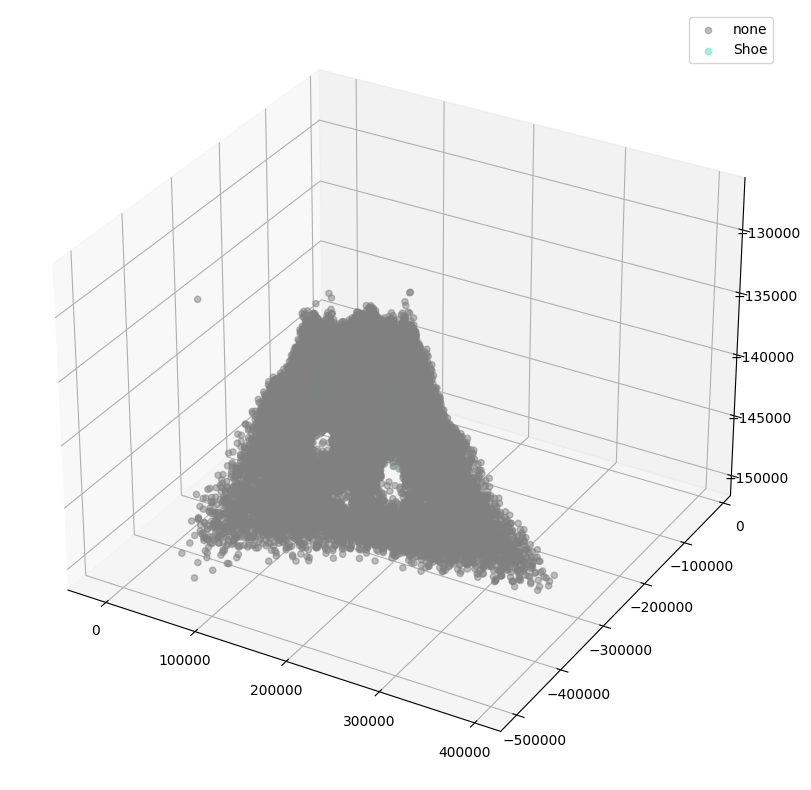

  8%|▊         | 1/13 [00:01<00:18,  1.56s/it]

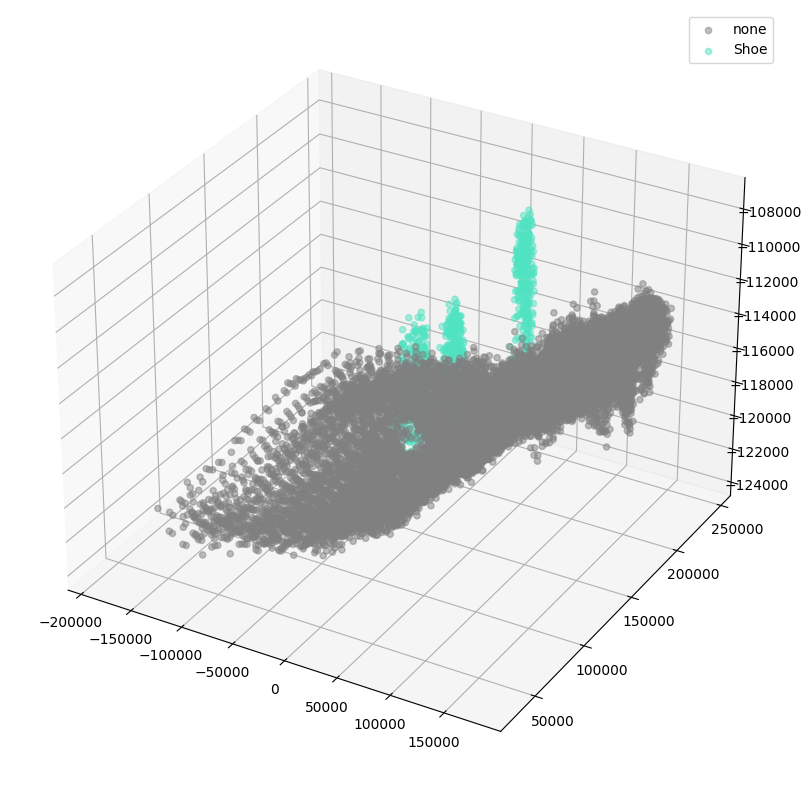

 15%|█▌        | 2/13 [00:03<00:18,  1.65s/it]

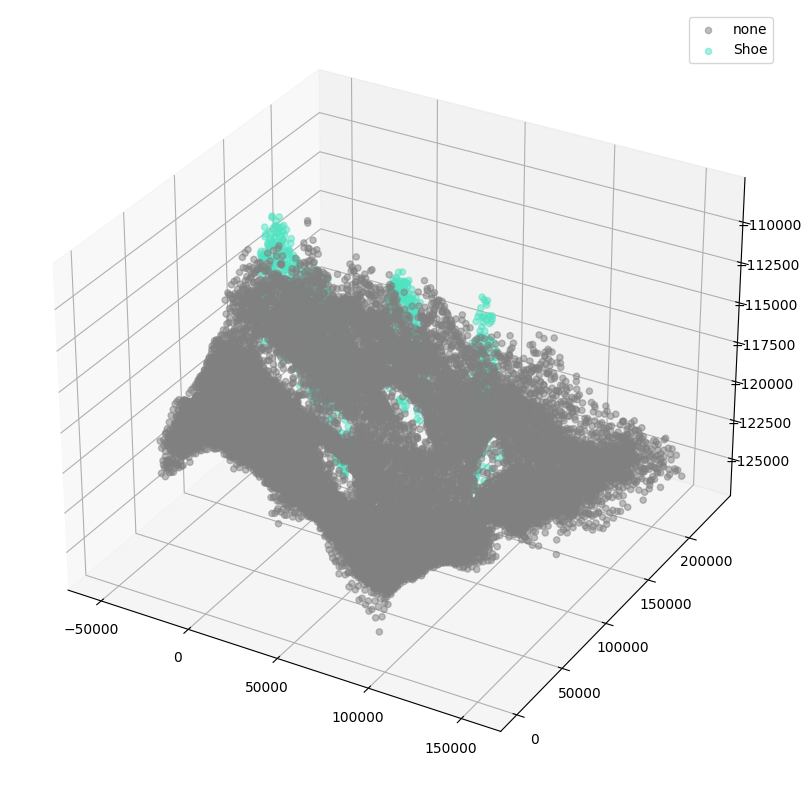

 23%|██▎       | 3/13 [00:04<00:16,  1.66s/it]

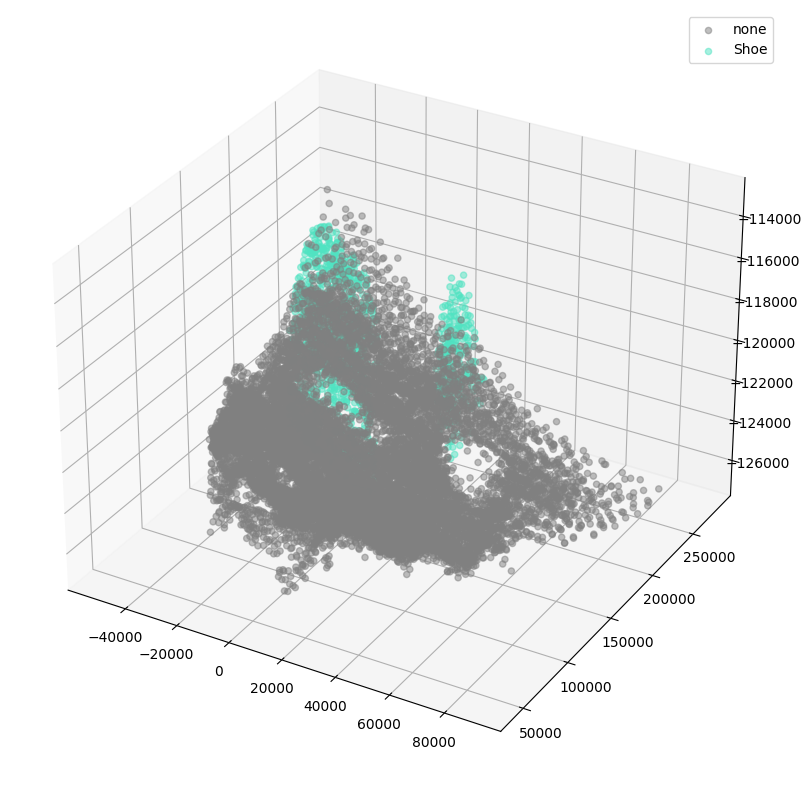

 31%|███       | 4/13 [00:06<00:13,  1.46s/it]

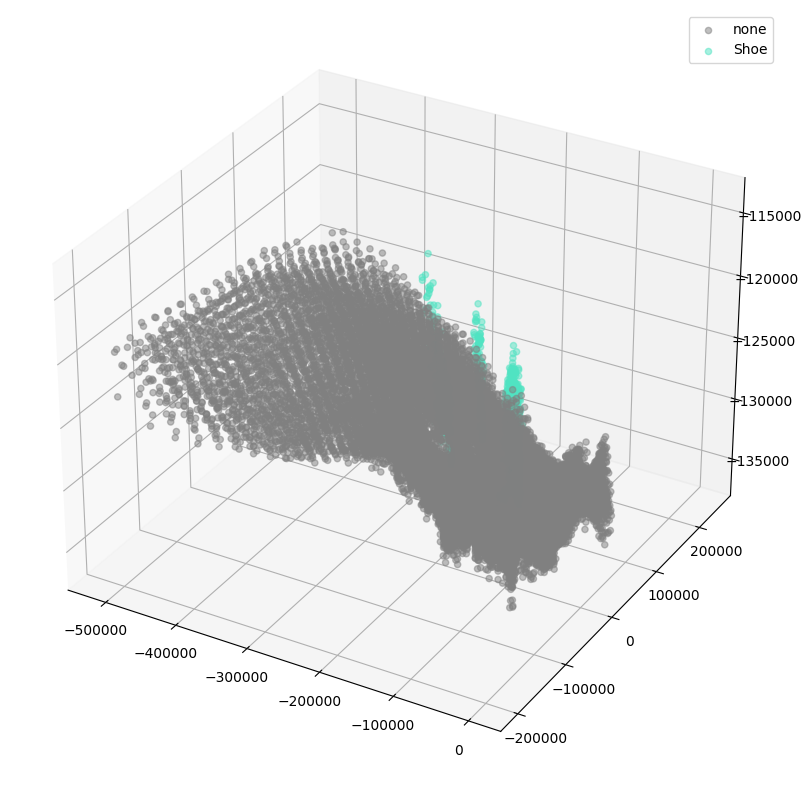

 38%|███▊      | 5/13 [00:07<00:12,  1.51s/it]

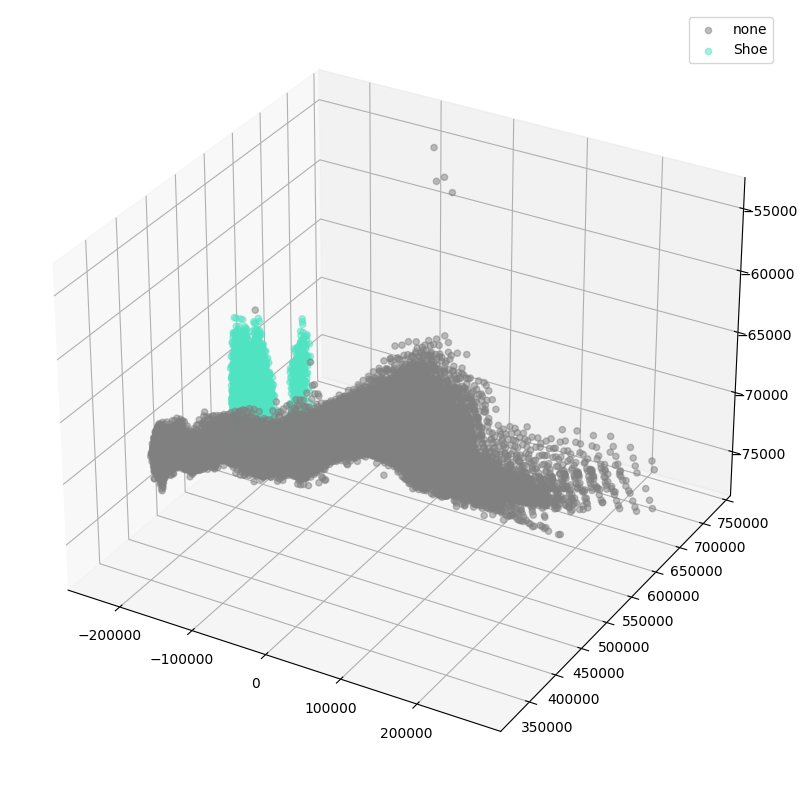

 46%|████▌     | 6/13 [00:09<00:10,  1.56s/it]

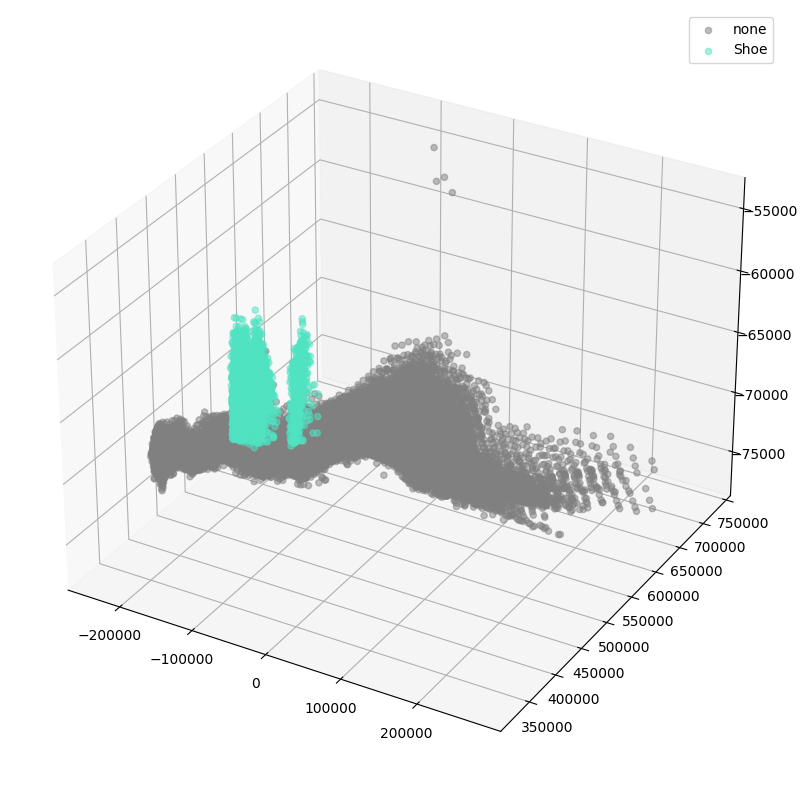

 54%|█████▍    | 7/13 [00:10<00:09,  1.57s/it]

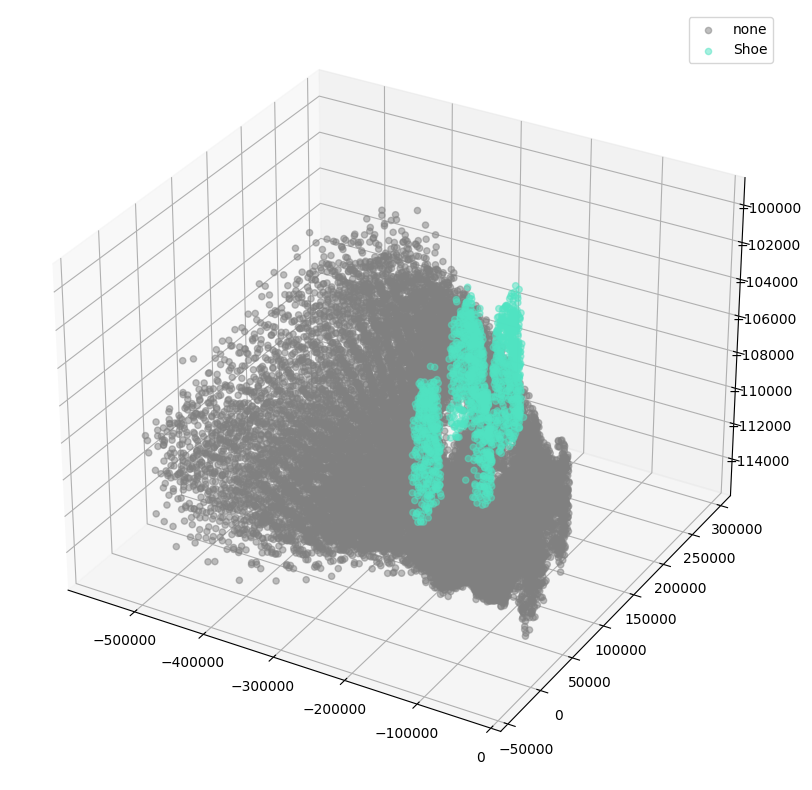

 62%|██████▏   | 8/13 [00:12<00:07,  1.49s/it]

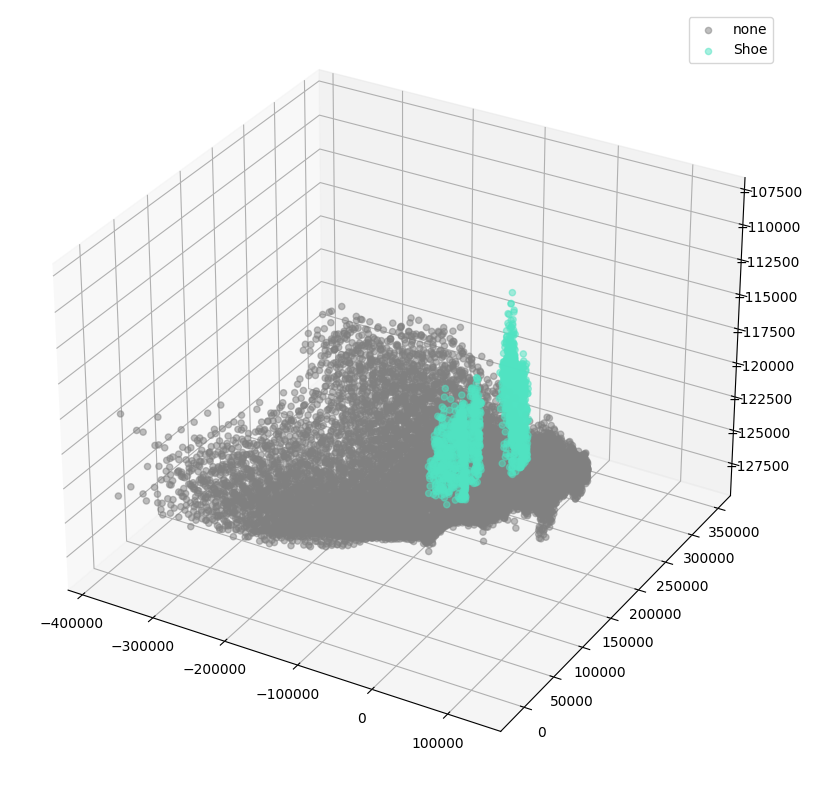

 69%|██████▉   | 9/13 [00:13<00:05,  1.49s/it]

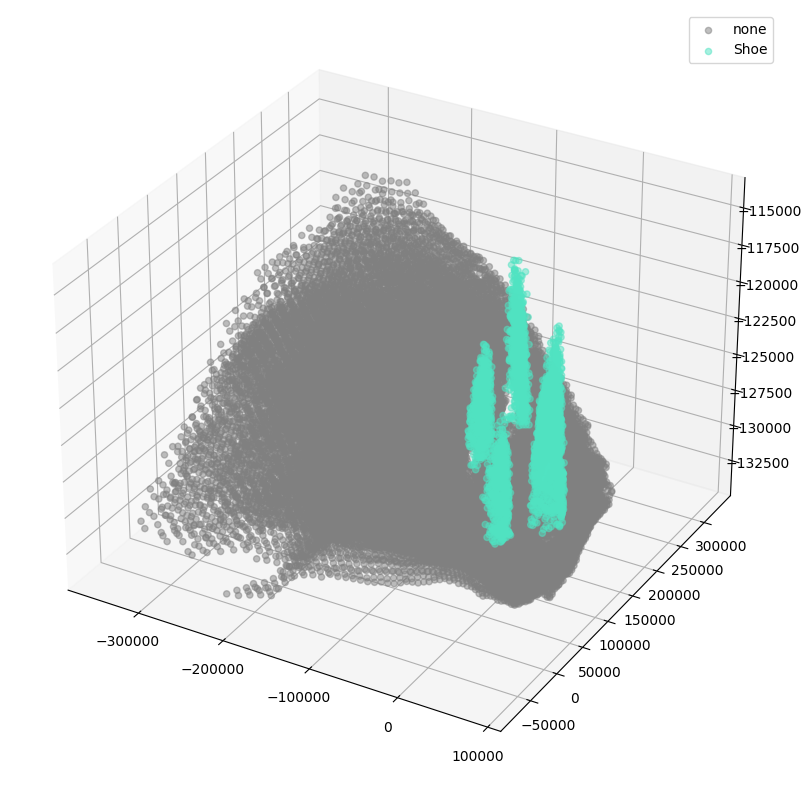

 77%|███████▋  | 10/13 [00:15<00:05,  1.69s/it]

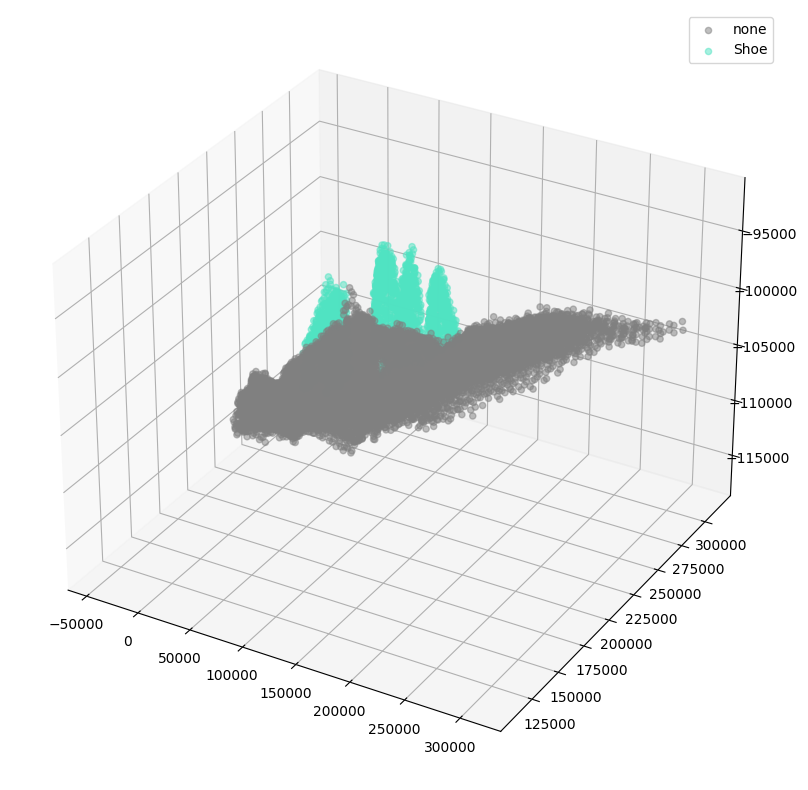

 85%|████████▍ | 11/13 [00:18<00:03,  1.87s/it]

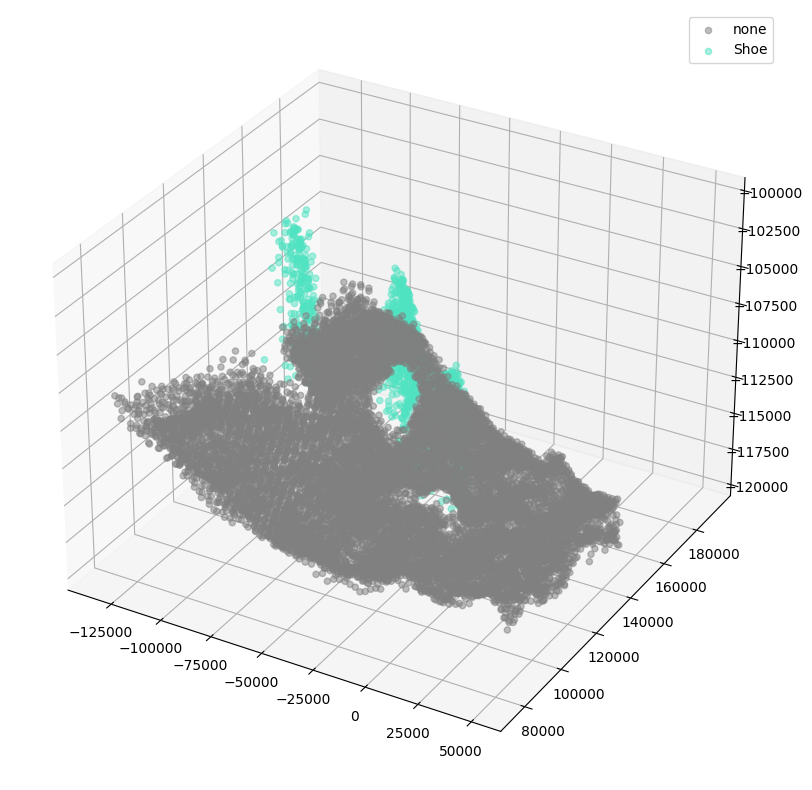

 92%|█████████▏| 12/13 [00:19<00:01,  1.69s/it]

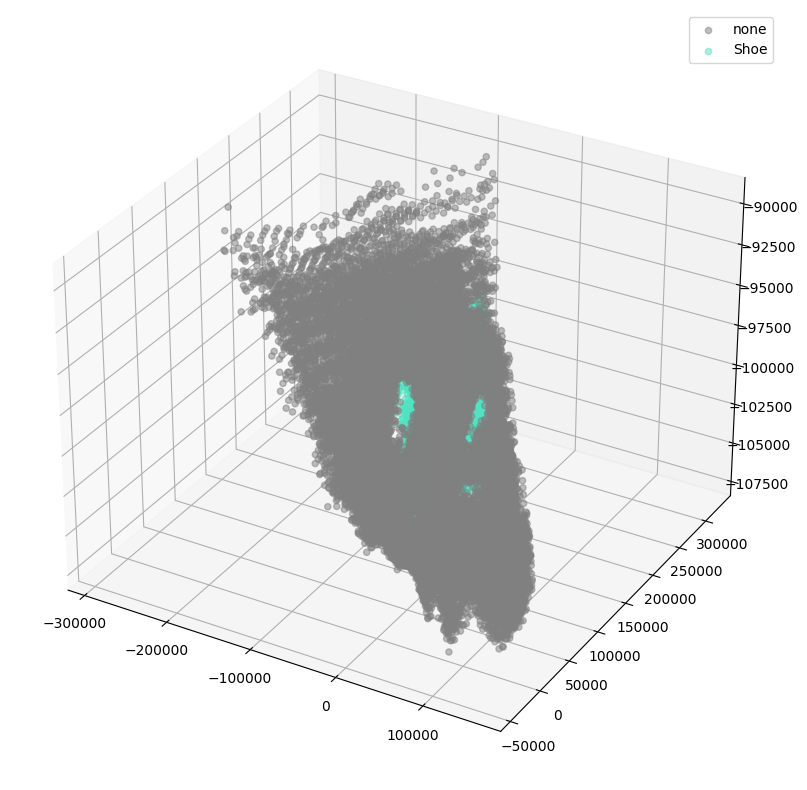

100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


In [16]:
def visualize_data(pc, labels):
    df = pd.DataFrame(
        data={
            "x": pc[:, 0],
            "y": pc[:, 1],
            "z": pc[:, 2],
            "label": labels
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for label in ALL_LABELS:
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=class_colors[label]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()

for i in tqdm(range(len(point_sets))):
    visualize_data(point_sets[i], point_set_labels[i])

In [22]:
LABEL_POINT_PATH = _annotation("all_labels/")

for i, ls in enumerate(tqdm(point_set_labels)):

    f = LABEL_POINT_PATH + _basename(annotations[i]) + ".txt"
    np.array(ls).tofile(f, sep=',', format='%s')


100%|██████████| 13/13 [00:00<00:00, 15.39it/s]
